<a href="https://colab.research.google.com/github/Library-of-jade/Kaggle_practice/blob/main/kaggle_study1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

코로나의 사망 위험을 결정 짓는 두가지 요인
- 연령(Age): 고령층은 코로나 19로 인한 사망 위험이 높음
- 기저질환(Illness/Morbidity): 기저질환이 있는 사람들은 코로나19로 인한 사망 위험이 높음


## BUT 여기서는 새로운 요인을 알아보자(행동요인)

### 1)확진자 행동 특성의 네 가지 유형

1. Hypermobile and hypersocial unknowns : 매우 높은 수준의 유동성과 사회성을 지닌 유형으로 감염 경로를 파악할 수 없으며 코로나19 확진을 늦게 받은 경향을 보인 유형


2.  Moderate groupies
: 유동성이 보통 수준이면서 다소 높은 수준의 사회적 교류 활동을 보이며 집단으로 감염된 유형. 증상 발현 후 코로나19 확진을 받기까지 평균 수준의 시간이 걸림


3. Social minimalists
: 유동성과 사회성의 수준이 보통보다 낮은 유형. 바이러스 감염자와의 직접 접촉으로 감염되었으며 확진 받기까지 평균 수준의 시간이 걸림.


4. Overseas non-essentialists
: 가장 낮은 유동성과 사회성을 보인 유형. 해외에서 유입되었고 증상 발현 이후 확진받기까지 가장 짧은 시간이 걸린 유형.

##2) 사망 위험과 관련된 주요 요인: 확진받기까지 걸린 시간

진단을 늦게 받을수록 치료와 관리가 늦어지기 때문에 사망자와 회복자로 나뉘게되는 요인 중 확진까지 걸리는 시간이다.

## **Feature Engineering**
행동 특성과 관련된 특징

1) 감염 경로 유형

2) 유동서

3) 접촉 정도

4) 확진받기까지 걸린 시간


In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
patient = pd.read_csv('/content/drive/MyDrive/Bootcamp/AI_8_스터디/kaggle필사/First/PatientInfo.csv')
patient.head(3)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released


In [ ]:
patient.shape

(3388, 18)

In [ ]:
data = patient.copy()

감염 경로 유형


In [ ]:
print('the number of unique values in infection_case:', len(data['infection_case'].unique()))
data['infection_case'].unique()

the number of unique values in infection_case: 24


array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Gyeongsan Seorin Nursing Home',
       'Gyeongsan Cham Joeun Community Center',
       'Gyeongsan Jeil Silver Town', 'Bonghwa Pureun Nursing Home',
       'Pilgrimage to Israel', 'Milal Shelter', 'Geochang Church',
       'Changnyeong Coin Karaoke'], dtype=object)

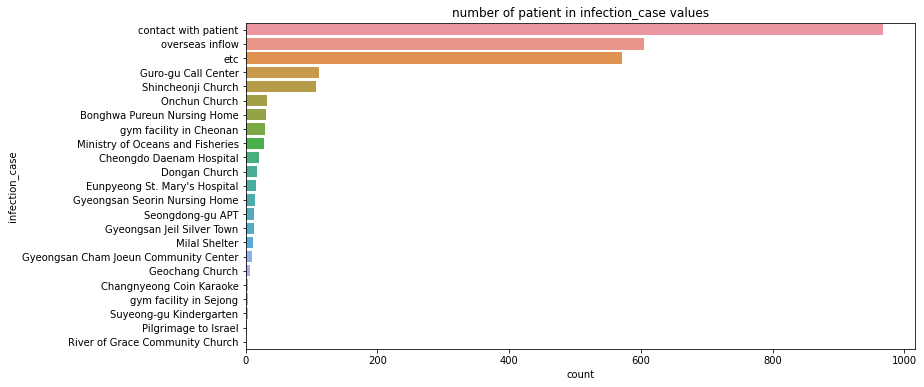

In [ ]:
g = data.groupby(['infection_case'])['patient_id'].count()
g = g.reset_index()
g.rename(columns={'patient_id' : 'count'}, inplace = True)

g = g.sort_values('count', ascending = False)

plt.figure(figsize=(12, 6))
plt.title("number of patient in infection_case values")
sns.barplot(y='infection_case', x='count', data =g)
display()

In [ ]:
g = data.groupby(['infection_case'])['patient_id'].count()
g = pd.DataFrame(g)

infection_case_less_than_5 = g[g['patient_id'] < 5].index.tolist()
g[g.index.isin(infection_case_less_than_5)]

,patient_id
infection_case,
Changnyeong Coin Karaoke,4
Pilgrimage to Israel,2
River of Grace Community Church,1
Suyeong-gu Kindergarten,3
gym facility in Sejong,4


In [ ]:
print("original data shape: ", data.shape)
data = data[~(data['infection_case'].isin(infection_case_less_than_5))]
print("data shape after slicing")

original data shape:  (3388, 18)
data shape after slicing


In [ ]:
data[data["infection_case"].isna()].shape

(768, 18)

In [ ]:
def categorisation(x):
  if x == 'overseas inflow':
    y = 'overseas'
  elif x == 'contact with patient':
    y = 'individual'
  elif (x == 'etc') | (pd.isna(x)):
    y = 'unknown'
  else:
    y = 'group'

  return y

data['infection'] = data['infection_case'].apply(lambda x:categorisation(x))
print(data.shape)
data.head()

(3374, 19)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual


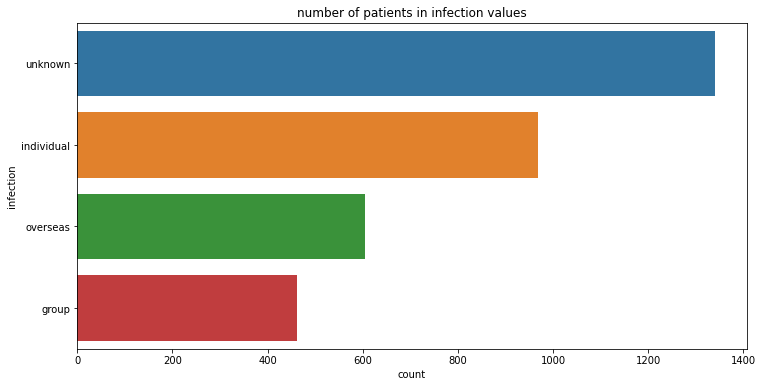

In [ ]:
g = data.groupby(['infection'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id': 'count'}, inplace = True)

g = g.sort_values('count', ascending = False)

plt.figure(figsize = (12,6))
sns.barplot(y = 'infection', x= 'count', data = g)
plt.title('number of patients in infection values')
display()

In [ ]:
route = pd.read_csv("/content/drive/MyDrive/Bootcamp/AI_8_스터디/kaggle필사/First/PatientRoute.csv")
route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.00,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.62,126.72
1,1000000001,2.00,2020-01-24,Seoul,Jung-gu,hospital,37.57,127.01
2,1000000002,5.00,2020-01-25,Seoul,Seongbuk-gu,etc,37.59,127.02
3,1000000002,5.00,2020-01-26,Seoul,Seongbuk-gu,store,37.59,127.02
4,1000000002,5.00,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.56,127.03


In [ ]:
print('the number of unique values in type:', len(route['type'].unique()))
route['type'].unique()

the number of unique values in type: 24


array(['airport', 'hospital', 'etc', 'store', 'public_transportation',
       'restaurant', 'church', 'beauty_salon', 'pharmacy', 'pc_cafe',
       'bank', 'cafe', 'bakery', 'bar', 'gym', 'school',
       'real_estate_agency', 'karaoke', 'post_office', 'gas_station',
       'lodging', 'academy', 'university', 'administrative_area_level_1'],
      dtype=object)

In [ ]:
route[route['type'].isna()].shape

(0, 8)

In [ ]:
leisure = ['library', 'theater', 'cafe', 'bakery', 'beauty_salon',
          'pc_cafe', 'billiards','restaurant', 'bar', 'karaoke']
travel = ['airport', 'lodging']
essential_edu = ['primary_school', 'school', 'university']
non_essential_edu = ['academy']
exercise = ['gym', 'mountain', 'park']
essential_admin = ['administrative_area_level_1', 'governmnet_office', 'post_office']
non_essential_admin = ['police_office', 'bank', 'real_estate_agency']
necessity = ['store', 'public_transportation', 'gas_station']
medical = ['hospital', 'pharmacy']
church = ['church']
etc = ['etc']

In [ ]:
essential = essential_edu + essential_admin + necessity + medical

def type_group_essen(x): 
     
    group = None
    if x in essential: 
        group = 'essential'
    else:
        group = 'non-essential' 
    return group 

route['route_group_essential'] = route['type'].apply(lambda x: type_group_essen(x)) 
route = route[['patient_id', 'type', 'route_group_essential']]
route.head()

,patient_id,type,route_group_essential
0,1000000001,airport,non-essential
1,1000000001,hospital,essential
2,1000000002,etc,non-essential
3,1000000002,store,essential
4,1000000002,public_transportation,essential


In [ ]:
route['route_value'] = 1
g = pd.DataFrame(route.groupby(['patient_id', 'route_group_essential'])['route_value'].count().unstack())
g

route_group_essential,essential,non-essential
patient_id,,
1000000001,1.00,1.00
1000000002,9.00,4.00
1000000003,nan,2.00
1000000004,1.00,nan
1000000005,1.00,nan
...,...,...
6100000086,2.00,2.00
6100000087,6.00,2.00
6100000088,5.00,19.00


In [ ]:
g.fillna(0, inplace = True)
g.reset_index(inplace = True)
g = g[['patient_id', 'essential', 'non-essential']]
g.head()

route_group_essential,patient_id,essential,non-essential
0,1000000001,1.00,1.00
1,1000000002,9.00,4.00
2,1000000003,0.00,2.00
3,1000000004,1.00,0.00
4,1000000005,1.00,0.00


In [ ]:
data = data.merge(g, left_on = 'patient_id', right_on = 'patient_id', how = 'left')
data.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas,9.00,4.00
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual,0.00,2.00
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual,1.00,0.00


In [ ]:
print(data.shape)
data[(data['essential'].isna()) | (data['non-essential'].isna())].shape

(3374, 21)


(2170, 21)

In [ ]:
print('original data shape:', data.shape)
data = data[(data['essential'].notna()) & (data['non-essential'].notna())] 
print('data shape after removing missing values in essentail/non-essential:', data.shape)

original data shape: (3374, 21)
data shape after removing missing values in essentail/non-essential: (1204, 21)


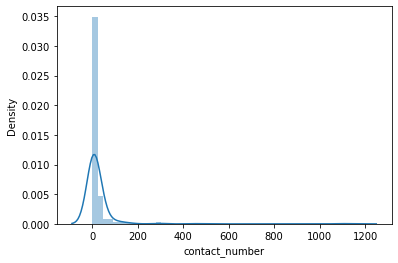

In [ ]:
sns.distplot(data['contact_number'])
display()

In [ ]:
data['contact_number'].describe()

count    332.00
mean      24.27
std       95.07
min        0.00
25%        2.00
50%        5.00
75%       17.25
max     1160.00
Name: contact_number, dtype: float64

In [ ]:
data[data['contact_number'] == 1160]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
764,1200000031,31.00,female,1959.00,60s,Korea,Daegu,NaN,NaN,Shincheonji Church,nan,nan,1160.00,NaN,2020-02-18,NaN,NaN,isolated,group,11.00,5.00


In [ ]:
print('original data shape:', data.shape)
data = data[data['contact_number'].notna()]
print('data shape after removing missing values in contact_number:', data.shape)

original data shape: (1204, 21)
data shape after removing missing values in contact_number: (332, 21)


In [ ]:
print('data shape:', data.shape)
print('missing values in symptom_onset_date:', data[data['symptom_onset_date'].isna()].shape)
print('missing values in confirmed_date:', data[data['confirmed_date'].isna()].shape)

data shape: (332, 21)
missing values in symptom_onset_date: (208, 21)
missing values in confirmed_date: (0, 21)
